# Deep Learning for Bot detection

### Author: Javier Pérez Clemente

In [26]:
import pandas as pd
import numpy as np
import os
import json
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
user_dtypes = {
    'id': object 
    , 'utc_offset': object
#     , 'default_profile': np.int64
}

tweets_dtypes = {
    'id': object, 
    'user_id': object,
    'in_reply_to_status_id': object,
    'in_reply_to_user_id': object,
    'retweeted_status_id': object,
    'geo': object
}

friends_dtypes = {
    'source_id': object, 
    'target_id': object
}

followers_dtypes = {
    'source_id': object, 
    'target_id': object
}
    
root_dir = './data/cresci-2015.csv/'
dirs = sorted(os.listdir(root_dir))

df_users = pd.DataFrame()
df_tweets = pd.DataFrame()
df_friends = pd.DataFrame()
df_followers = pd.DataFrame()

for item in dirs:
    if os.path.isdir(root_dir + item):
        with open(root_dir + item + '/users.csv', 'rb') as users_file:
            is_bot = 1 if item in ['INT.csv', 'FSF.csv', 'TWT.csv'] else 0
            new_users = pd.read_csv(users_file, dtype = user_dtypes)
            new_users['bot'] = is_bot
            df_users = pd.concat([df_users, new_users])
            
#         with open(root_dir + item + '/tweets.csv', 'rb') as tweets_file:
#             df_tweets = pd.concat([df_tweets, pd.read_csv(tweets_file, dtype = tweets_dtypes)])
            
#         with open(root_dir + item + '/friends.csv', 'rb') as friends_file:
#             df_friends = pd.concat([df_friends, pd.read_csv(friends_file, dtype = friends_dtypes)])
            
#         with open(root_dir + item + '/followers.csv', 'rb') as followers_file:
#             df_followers = pd.concat([df_followers, pd.read_csv(followers_file, dtype = followers_dtypes)])

## Exploratory Data Analysis

|VARIABLE|STATUS|
|:--|:-------------------|
|id|Not usefull. Dropped|
|name|Not usefull. Dropped|
|screen_name|Not usefull. Dropped|
|statuses_coun|np.int64|
|followers_count|np.int64|
|friends_count|np.int64|
|favourites_count|np.int64|
|listed_count|np.int64|
|created_at|Not usefull. Dropped|
|url|Converted to binary|
|lang|Not usefull. Dropped|
|time_zone|Not usefull. Dropped|
|location|Not usefull. Dropped|
|default_profile|Binary NaNs to 0|
|default_profile_image|Binary NaNs to 0|
|geo_enabled|Binary NaNs to 0|
|profile_image_url|Not usefull. Dropped. Impossible to convert to binary since there are no NaNs					 |
|profile_banner_url|Binary NaNs to 0|
|profile_use_background_image|Binary NaNs to 0|
|profile_background_image_url_https|Repeated. Dropped|
|profile_text_color|Not sure what to do. Likely to be dropped|
|profile_image_url_https|Repeated. Dropped|
|profile_sidebar_border_color|Not sure what to do. Likely to be dropped|
|profile_background_tile|Binary NaNs to 0|
|profile_sidebar_fill_color|Not sure what to do. Likely to be dropped|
|profile_background_image_url|Not usefull. Dropped. Impossible to convert to binary since there are no NaNs|
|profile_background_color|Not sure what to do. Likely to be dropped|
|profile_link_color|Not sure what to do. Likely to be dropped|
|utc_offset|Not usefull. Dropped|
|protected|Not usefull. Dropped. Impossible to convert to binary since there are only NaNs|
|verified|Not usefull. Dropped. Impossible to convert to binary since there are only NaNs|
|description|Converted to bins of length(description). Most of the rows with length(description) < 5 are bots|
|updated|Not usefull. Dropped|
|dataset|Not usefull. Dropped|
|bot|label|

In [4]:
def amend_binary(df, var):
    df[var] = pd.to_numeric(df[var]).fillna(0).map(np.int64)
    return df

def to_dummie(df, var):
    var_dummies = pd.get_dummies(df.loc[:, var])
    print(var_dummies.shape)
    df.drop(var, axis=1, inplace=True)
    df = pd.concat([df, var_dummies], axis=1)
    return df

def to_dummies(df, variables):
    for var in variables:
        df = to_dummie(df, var)
    return df

def to_binary(df, var):
    df[var] = np.where(df[var].isnull(), 0, 1)
    return df

def to_binaries(df, variables):
    for var in variables:
        df = to_binary(df, var)
    return df

user_binary_vars = ['geo_enabled', 'profile_use_background_image', 'default_profile', 'default_profile_image', 'profile_background_tile', 'protected', 'verified']
for var in user_binary_vars:
            df_users = amend_binary(df_users, var)
    
# tweet_binary_vars = ['truncated']
# for var in tweet_binary_vars:
#     df_tweets = to_binary(df_tweets, var)

# Variables convertidas a binarias.
to_binary_vars = ['url', 'profile_image_url', 'profile_banner_url', 'profile_background_image_url']
df_users = to_binaries(df_users, to_binary_vars)

df_users.loc[:,'descr_longr_5'] = np.where(df_users.loc[:,'description'].map(lambda x: len(str(x))) > 5, 1, 0)

# Variables dummies. Estas variables de momento no entrarían en el modelo.
# df_users = to_dummies(df_users, ['lang', 'time_zone']) 

# Variables a eliminar
df_users.drop(['id','screen_name', 'name','created_at', 'location', 'lang', 'time_zone', 'profile_text_color', 'profile_sidebar_border_color','profile_image_url_https', 'profile_image_url', 'profile_background_image_url_https', 'protected', 'verified', 'updated', 'dataset', 'description', 'utc_offset', 'profile_sidebar_fill_color', 'profile_background_color', 'profile_link_color', 'profile_background_image_url'], axis=1, inplace=True)

In [6]:
df_users.dtypes

statuses_count                  int64
followers_count                 int64
friends_count                   int64
favourites_count                int64
listed_count                    int64
url                             int64
default_profile                 int64
default_profile_image           int64
geo_enabled                     int64
profile_banner_url              int64
profile_use_background_image    int64
profile_background_tile         int64
bot                             int64
descr_longr_5                   int64
dtype: object

### Variable "statuses_count"

Text(0, 0.5, 'count')

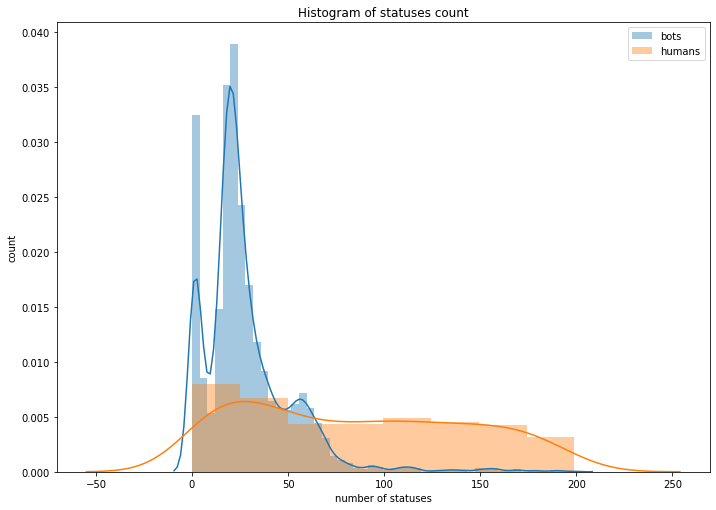

In [72]:
df_users['statuses_count'].value_counts().max()

a4_dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize=a4_dims)

bots = df_users.loc[df_users['bot'] == 1]
humans = df_users.loc[df_users['bot'] ==0]
sns.distplot(bots.loc[bots['statuses_count'] < 200,'statuses_count'], label='bots')
sns.distplot(humans.loc[humans['statuses_count'] < 200,'statuses_count'], label='humans')

plt.legend()
plt.title('Histogram of statuses count')
plt.xlabel('number of statuses')
plt.ylabel('count')

Text(0, 0.5, 'count')

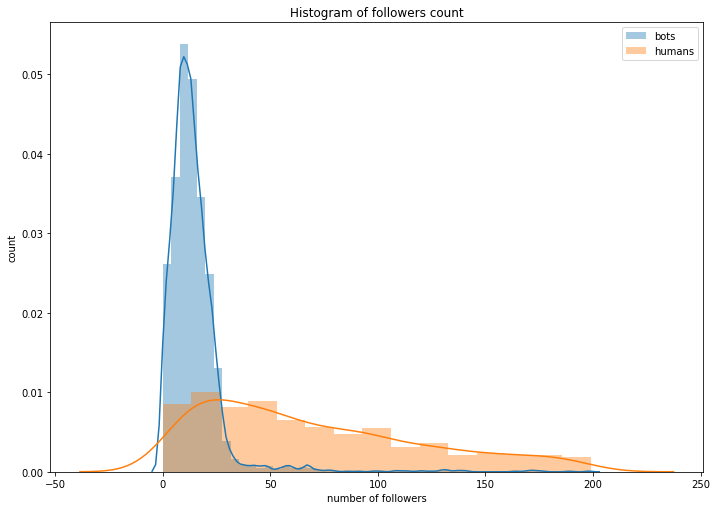

In [70]:
a4_dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize=a4_dims)

bots = df_users.loc[df_users['bot'] == 1]
humans = df_users.loc[df_users['bot'] ==0]
sns.distplot(bots.loc[bots['followers_count'] < 200,'followers_count'], label='bots')
sns.distplot(humans.loc[humans['followers_count'] < 200,'followers_count'], label='humans')

plt.legend()
plt.title('Histogram of followers count')
plt.xlabel('number of followers')
plt.ylabel('count')

### Variable "description"

W0802 13:33:48.323475 140460422309696 legend.py:1282] No handles with labels found to put in legend.


Text(0.5, 1.0, 'Histogram of Arrival Delays')

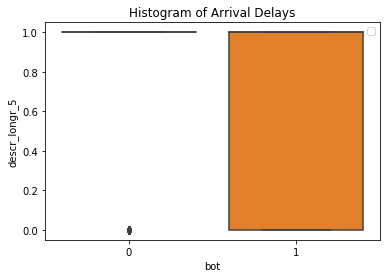

In [30]:
sns.boxplot(data = df_users, x="bot", y="descr_longr_5")

# Add labels
plt.legend()
plt.title('Histogram of Arrival Delays')
#plt.xlabel('description greater than 5 chars')

### Corretlations

In [ ]:
df = df_users

f = plt.figure(figsize=(19, 15))
plt.matshow(df.corr(), fignum=f.number)
plt.xticks(range(df.shape[1]), df.columns, fontsize=14, rotation=90)
plt.yticks(range(df.shape[1]), df.columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=14);

col_names = df.corr().columns.values

for col, row in ((df.corr().abs() > 0.8) & (df.corr().abs() < 1)).iteritems():
    print(col, col_names[row.values])

In [7]:
df_users.corr()

,statuses_count,followers_count,friends_count,favourites_count,listed_count,url,default_profile,default_profile_image,geo_enabled,profile_banner_url,profile_use_background_image,profile_background_tile,bot,descr_longr_5
statuses_count,1.000000,0.074241,0.399657,0.432268,0.406561,0.260933,-0.294773,-0.011784,0.234040,0.316408,-0.080809,0.188934,-0.322735,0.128251
followers_count,0.074241,1.000000,0.107956,0.032073,0.510324,0.071857,-0.051772,-0.002660,0.021379,0.055402,-0.008234,0.006432,-0.050821,0.021721
friends_count,0.399657,0.107956,1.000000,0.176416,0.585346,0.126125,-0.121381,-0.012440,0.084069,0.081611,-0.011994,0.096829,-0.036776,-0.015536
favourites_count,0.432268,0.032073,0.176416,1.000000,0.074568,0.064378,-0.148081,0.000158,0.101764,0.178186,-0.021582,0.108274,-0.163759,0.067025
listed_count,0.406561,0.510324,0.585346,0.074568,1.000000,0.202370,-0.141999,-0.007309,0.112214,0.132202,-0.066718,0.051769,-0.141662,0.059065
url,0.260933,0.071857,0.126125,0.064378,0.202370,1.000000,-0.423796,-0.028978,0.354011,0.332926,-0.120545,0.233416,-0.441359,0.154851
default_profile,-0.294773,-0.051772,-0.121381,-0.148081,-0.141999,-0.423796,1.000000,0.035833,-0.470905,-0.568878,0.193232,-0.590658,0.641482,-0.150151
default_profile_image,-0.011784,-0.002660,-0.012440,0.000158,-0.007309,-0.028978,0.035833,1.000000,-0.021570,-0.025783,0.009199,-0.020252,-0.055978,-0.089404
geo_enabled,0.234040,0.021379,0.084069,0.101764,0.112214,0.354011,-0.470905,-0.021570,1.000000,0.453350,-0.130363,0.258242,-0.535416,0.142821
profile_banner_url,0.316408,0.055402,0.081611,0.178186,0.132202,0.332926,-0.568878,-0.025783,0.453350,1.000000,-0.146982,0.339583,-0.675197,0.232836


La variable default_profile tiene presenta una correlación de 0.64 con la variable de salida. Esto nos indica que será importante en el modelo

## Training and testing division

In [8]:
from sklearn.model_selection import train_test_split

# fix random seed for reproducibility
seed = 7
np.random.seed(seed)

y = df_users.loc[:, 'bot']
X = df_users.loc[:, df_users.columns != 'bot']

X_train, X_remain, y_train, y_remain \
    = train_test_split(X, y, train_size=0.8)

X_test, X_val, y_test, y_val \
    = train_test_split(X_remain, y_remain, test_size=0.5)

In [9]:
print(df_users.shape)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
print(X_val.shape)
print(y_val.shape)

(5301, 14)
(4240, 13)
(4240,)
(530, 13)
(530,)
(531, 13)
(531,)


## Model implementation

In [10]:
from keras.models import Sequential, Model
from keras.layers import Input, Dense
from keras.utils import plot_model
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix
import keras

epochs = 10
batch_size = 5

Using TensorFlow backend.


In [11]:
def auc(y_true, y_pred):
    auc = tf.metrics.auc(y_true, y_pred)[1]
    K.get_session().run(tf.local_variables_initializer())
    return auc


def create_baseline():
    # create model
    model = Sequential()
    model.add(Dense(10, input_dim=13, kernel_initializer='normal', activation='relu'))
    model.add(Dense(5, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal', activation='sigmoid'))
    
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model
    

# evaluate model with standardized dataset
model = create_baseline()

model.summary()

plot_model(model, to_file='model.png')

W0802 13:10:54.323359 140460422309696 deprecation_wrapper.py:119] From /home/osboxes/miniconda3/envs/tfm/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0802 13:10:54.348275 140460422309696 deprecation_wrapper.py:119] From /home/osboxes/miniconda3/envs/tfm/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0802 13:10:54.351303 140460422309696 deprecation_wrapper.py:119] From /home/osboxes/miniconda3/envs/tfm/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4115: The name tf.random_normal is deprecated. Please use tf.random.normal instead.

W0802 13:10:54.392239 140460422309696 deprecation_wrapper.py:119] From /home/osboxes/miniconda3/envs/tfm/lib/python3.7/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.co

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 10)                140       
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 55        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 6         
Total params: 201
Trainable params: 201
Non-trainable params: 0
_________________________________________________________________


Mean estimated accuracy and standard deviation (average spread)

In [12]:
estimator = KerasClassifier(build_fn=create_baseline, epochs=epochs, batch_size=batch_size, verbose=0)

kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
results_train = cross_val_score(estimator, X_train, y_train, cv=kfold)

print("Train Results: %.2f%% (%.2f%%)" % (results_train.mean()*100, results_train.std()*100))

W0802 13:11:03.091368 140460422309696 deprecation_wrapper.py:119] From /home/osboxes/miniconda3/envs/tfm/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.



Train Results: 97.52% (0.54%)


In [13]:
# x_train and y_train are Numpy arrays --just like in the Scikit-Learn API.
model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size)

Epoch 1/10
4240/4240 [==============================] - 5s 1ms/step - loss: 0.2895 - acc: 0.9123
Epoch 2/10
4240/4240 [==============================] - 4s 964us/step - loss: 0.1806 - acc: 0.9634
Epoch 3/10
4240/4240 [==============================] - 4s 907us/step - loss: 0.1520 - acc: 0.9712
Epoch 4/10
4240/4240 [==============================] - 4s 929us/step - loss: 0.1328 - acc: 0.9750
Epoch 5/10
4240/4240 [==============================] - 4s 893us/step - loss: 0.1180 - acc: 0.9771
Epoch 6/10
4240/4240 [==============================] - 4s 979us/step - loss: 0.1065 - acc: 0.9797
Epoch 7/10
4240/4240 [==============================] - 5s 1ms/step - loss: 0.1020 - acc: 0.9783
Epoch 8/10
4240/4240 [==============================] - 4s 937us/step - loss: 0.0998 - acc: 0.9783
Epoch 9/10
4240/4240 [==============================] - 4s 914us/step - loss: 0.0905 - acc: 0.9788
Epoch 10/10
4240/4240 [==============================] - 4s 966us/step - loss: 0.0872 - acc: 0.9797


In [15]:
score = model.evaluate(X_train, y_train, verbose=0)
print('Test loss:', score[0])
print('Train accuracy:', score[1])

Test loss: 0.0746435912150257
Train accuracy: 0.9804245283018868


In [16]:
score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.09531562806300398
Test accuracy: 0.9716981123078544


In [24]:
score = model.evaluate(X_val, y_val, verbose=0)
print('Validation loss:', score[0])
print('Validation accuracy:', score[1])

Validation loss: 0.09663098949497029
Validation accuracy: 0.9792843699006262


Test accuracy for 10 k-fold cross validation

In [18]:
print("Train Results: %.2f%% (%.2f%%)" % (results_train.mean()*100, results_train.std()*100))

Train Results: 97.52% (0.54%)


In [20]:
y_pred = model.predict_classes(X_test, batch_size=batch_size)
y_pred

tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

In [21]:
accuracy = (tp + tn)/(tp + tn + fp + fn)
precission = tp/(tp+tn)

In [22]:
accuracy

0.9716981132075472

In [23]:
precission

0.6213592233009708